# Training an ML Model on Tensorflow Datasets
## Prerequisites

In [1]:
import json
import os
from typing import Callable, Optional, List

import numpy as np
import pandas as pd
import tensorflow as tf
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation, layers, losses

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [4]:
#tf.debugging.set_log_device_placement(True)
GPUs = tf.config.list_physical_devices('GPU')
GPUs

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Configuration

In [5]:
%pwd

'/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks'

In [6]:
DATA_SOURCE = 'pride'
# DATA_SOURCE = 'pdeep'

In [7]:
if DATA_SOURCE == 'pride':
    PROJECT = "PXD010000"
    DUMP_PATH = os.path.join("/scratch/mirko.krause/dumps/", PROJECT)
elif DATA_SOURCE == 'pdeep':
    DUMP_PATH = "/scratch/mirko.krause/pdeep"
else:
    assert False

In [8]:
print(f"dump path = {DUMP_PATH}")
THREAD_COUNT = min(int(os.cpu_count()/2), 16)
TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "*_mzmlid.parquet")
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

dump path = /scratch/mirko.krause/dumps/PXD010000


In [9]:
SEQ = 'peptide_sequence'

In [10]:
logger = log.create_logger(
    name='mmproteo_dense_model',
    verbose=True,
    log_dir=DUMP_PATH,
)

2021-10-23 13:05:04,726 - mmproteo_dense_model: Logging to file '/scratch/mirko.krause/dumps/PXD010000/mmproteo_dense_model.log' and to stderr


In [11]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 2354,
  'intensity_array': 2354,
  'peptide_sequence': 50},
 'idx_to_char': {'2': 'A',
  '3': 'C',
  '4': 'D',
  '5': 'E',
  '6': 'F',
  '7': 'G',
  '8': 'H',
  '9': 'I',
  '10': 'K',
  '11': 'L',
  '12': 'M',
  '13': 'M(Oxidation)',
  '14': 'N',
  '15': 'P',
  '16': 'Q',
  '17': 'R',
  '18': 'S',
  '19': 'T',
  '20': 'V',
  '21': 'W',
  '22': 'Y',
  '0': '_',
  '1': 'EOS'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7f68e0932ca0>'},
 'split_value_columns': ['species', 'istrain'],
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence'],
 'element_spec': '((TensorSpec(shape=(2354,), dtype=tf.float32, name=None), TensorSpec(shape=(2354,), dtype=tf.float32, name=None)), (TensorSpec(shape=(50,), dtype=tf.int8, name=None),))',
 'eos_idx': 1}

In [12]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [13]:
KEEP_CACHE = True

In [14]:
TRAIN_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [15]:
def find_grouping_path_position(cols: Optional[List[str]], prefered_item: str, alternative_index: int = -1) -> int:
    res = alternative_index
    if cols is not None:
        try:
            res = cols.index(prefered_item) - len(cols)
        except ValueError:
            pass
    return res

In [16]:
grouping_path_position = find_grouping_path_position(
    cols=PROCESSING_INFO['split_value_columns'],
    prefered_item='species',
    alternative_index=-1,
)
grouping_path_position

-2

In [17]:
os.path.join(
        DATASET_DUMP_PATH, 
        '*',  # filename
        *(['*' for _ in PROCESSING_INFO['split_value_columns']] or [])
    )

'/scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/*/*/*'

In [18]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path = os.path.join(
        DATASET_DUMP_PATH, 
        '*',  # filename
        *(['*' for _ in PROCESSING_INFO['split_value_columns']] or [])
    ),
    path_position = grouping_path_position,
    splits = {
            TRAIN_TYPE: 0.8,
            TEST_TYPE: 0.9,
            EVAL_TYPE: 1.0
        },
    paths_dump_file = os.path.join(
            DATASET_DUMP_PATH,
            "dataset_file_paths.json"
        ),
    skip_existing = KEEP_CACHE,
    logger = logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)


assigned dataset files:
#Train = 190
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/Biodiversity_B_bifidum_CMcarb_anaerobic_03_26Feb16_Arwen_16-01-01_mzmlid.parquet/Bifidobacterium_bifidum_ATCC29521/Train
#Test = 24
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/Biodiversity_F_novicida_TSB_aerobic_03_01Feb16_Arwen_15-07-13_mzmlid.parquet/Francisella_novicida_U112/Train
#Eval = 21
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/S_venezuelae_GYM_1_21Mar16_Arwen_16-01-03_mzmlid.parquet/Streptomyces_venezuelae/Train


2021-10-23 13:05:04,756 - mmproteo_dense_model: found file paths dump '/scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/dataset_file_paths.json'


### Loading corresponding TF datasets

In [19]:
element_spec = eval(PROCESSING_INFO['element_spec'], {}, {'TensorSpec':tf.TensorSpec, 'tf':tf})
element_spec

((TensorSpec(shape=(2354,), dtype=tf.float32, name=None),
  TensorSpec(shape=(2354,), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(50,), dtype=tf.int8, name=None),))

In [20]:
# initialize Tensorflow (might take several minutes (~5 minutes per GPU with 40GB VRAM each))
logger.debug("started initializing tensorflow by creating a first dataset")
tf.data.Dataset.range(5)
logger.info("finished initializing tensorflow")

2021-10-23 13:05:04,764 - mmproteo_dense_model: DEBUG: started initializing tensorflow by creating a first dataset
2021-10-23 13:10:19,578 - mmproteo_dense_model: finished initializing tensorflow


In [21]:
ds_options = tf.data.Options()
ds_options.experimental_threading.private_threadpool_size = THREAD_COUNT
ds_options.experimental_threading.max_intra_op_parallelism = THREAD_COUNT

In [22]:
BATCH_SIZE=32

In [23]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    thread_count=min(int(os.cpu_count()/4), 4),
    keep_cache=KEEP_CACHE,
    logger=logger,
    run_benchmarks=False,
    options=ds_options,
).load_datasets_by_type(dataset_file_paths)
datasets

2021-10-23 13:10:19,607 - mmproteo_dense_model: DEBUG: preparing dataset 'Train' with 190 paths
2021-10-23 13:10:19,626 - mmproteo_dense_model: DEBUG: applied options to dataset 'Train'
2021-10-23 13:10:19,798 - mmproteo_dense_model: DEBUG: loaded dataset 'Train' interleaved
2021-10-23 13:10:19,799 - mmproteo_dense_model: DEBUG: skipped caching dataset 'Train'
2021-10-23 13:10:19,800 - mmproteo_dense_model: DEBUG: shuffled dataset 'Train'
2021-10-23 13:10:19,801 - mmproteo_dense_model: DEBUG: batched dataset 'Train'
2021-10-23 13:10:19,802 - mmproteo_dense_model: DEBUG: configured prefetching for dataset 'Train'
2021-10-23 13:10:19,802 - mmproteo_dense_model: DEBUG: skipped benchmarking dataset 'Train'
2021-10-23 13:10:19,802 - mmproteo_dense_model: prepared dataset 'Train'
2021-10-23 13:10:19,802 - mmproteo_dense_model: DEBUG: preparing dataset 'Test' with 24 paths
2021-10-23 13:10:19,803 - mmproteo_dense_model: DEBUG: applied options to dataset 'Test'
2021-10-23 13:10:19,811 - mmprot

{'Train': <PrefetchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Test': <PrefetchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Eval': <PrefetchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>}

## Building the Tensorflow Model

In [24]:
from tensorflow.python.keras.metrics import MeanMetricWrapper
from tensorflow.python.ops import array_ops, math_ops
from tensorflow.python.keras import backend
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K

In [25]:
def jaccard_distance(elem):
    i_true, i_pred = elem[0], elem[1]
    unique_true, _ = tf.unique(i_true)
    unique_pred, _ = tf.unique(i_pred)
    n_unique_true = tf.shape(unique_true)[0]
    n_unique_pred = tf.shape(unique_pred)[0]
    unique_all, _ = tf.unique(tf.concat(values=[unique_true, unique_pred], axis=-1))
    n_unique_all = tf.shape(unique_all)[0]
    n_overlap = n_unique_true + n_unique_pred - n_unique_all
    return n_overlap / n_unique_all

def jaccard_batch_distance(y_true, y_pred):
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = ops.convert_to_tensor_v2_with_dispatch(y_true)
    y_pred_rank = y_pred.shape.ndims
    y_true_rank = y_true.shape.ndims
    # If the shape of y_true is (num_samples, 1), squeeze to (num_samples,)
    if (y_true_rank is not None) and (y_pred_rank is not None) and (len(
            backend.int_shape(y_true)) == len(backend.int_shape(y_pred))):
        y_true = array_ops.squeeze(y_true, [-1])
    y_pred = math_ops.argmax(y_pred, axis=-1)

    # If the predicted output and actual output types don't match, force cast them
    # to match.
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))
    
    # 0th dimension is the batch
    jaccard = tf.map_fn(fn=jaccard_distance, elems=(y_true, y_pred), fn_output_signature=tf.float64)
    return math_ops.cast(jaccard, backend.floatx())
    

class JaccardBatchDistance(MeanMetricWrapper):
    def __init__(self, name='jaccard_batch_distance', dtype=None):
        super(JaccardBatchDistance, self).__init__(
            jaccard_batch_distance, name, dtype=dtype)

In [26]:
def leuvenshtein_sparse_tensor_batch_distance(y_true: tf.sparse.SparseTensor, y_pred: tf.sparse.SparseTensor) -> tf.Tensor:
    return tf.edit_distance(
        hypothesis=y_pred,
        truth=y_true,
        normalize=False,
    )

def leuvenshtein_batch_distance(y_true: tf.Tensor, y_pred: tf.Tensor, sparse_pred: bool = True) -> tf.Tensor:
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = ops.convert_to_tensor_v2_with_dispatch(y_true)
    
    if sparse_pred:
        y_pred = math_ops.argmax(y_pred, axis=-1)
    
    y_pred = tf.sparse.from_dense(y_pred)
    y_true = tf.sparse.from_dense(y_true)

    # If the predicted output and actual output types don't match, force cast them
    # to match.
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))
    
    # 0th dimension is the batch
    leuvenshtein = leuvenshtein_sparse_tensor_batch_distance(y_true, y_pred)
    return math_ops.cast(leuvenshtein, backend.floatx())
    

class LeuvenshteinBatchDistance(MeanMetricWrapper):
    def __init__(self, name='leuvenshtein_batch_distance', dtype=None):
        super(LeuvenshteinBatchDistance, self).__init__(
            leuvenshtein_batch_distance, name, dtype=dtype)

In [27]:
input_layers_list, masked_input_layers_list = layers.create_masked_input_layers(
    [
        layers.InputLayerConfiguration(
            name=col,
            shape=PROCESSING_INFO['padding_lengths'][col],
            mask_value=PROCESSING_INFO['padding_characters'][col]
        )
        for col in PROCESSING_INFO['training_data_columns']
    ]
)
print(input_layers_list)
print(masked_input_layers_list)

[<KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'mz_array')>, <KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'intensity_array')>]
[<KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'masked_mz_array')>, <KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'masked_intensity_array')>]


In [28]:
x = tf.stack(
    values=masked_input_layers_list, 
    axis=-1,
)

x = tf.keras.layers.Flatten(name="flattened_masked_inputs")(x)

for _ in range(4):
    x = tf.keras.layers.Dense(2**11)(x)
    #x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Dense(PROCESSING_INFO['padding_lengths'][SEQ]*len(idx_to_char))(x)

x = tf.reshape(x,(-1, PROCESSING_INFO['padding_lengths'][SEQ], len(idx_to_char)))

x = tf.keras.activations.softmax(x)

model = tf.keras.Model(
    inputs=input_layers_list, 
    outputs=x, 
    name=f"mmproteo_dense_{DATA_SOURCE}_{utils.get_current_time_str()}")
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate = 10**-5
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(),
        JaccardBatchDistance(),
        LeuvenshteinBatchDistance(),
    ]
)

In [29]:
MODEL_PATH = os.path.join(DUMP_PATH, "models", model.name)
MODEL_PATH

'/scratch/mirko.krause/dumps/PXD010000/models/mmproteo_dense_pride_20211023-131020'

In [30]:
utils.ensure_dir_exists(MODEL_PATH)

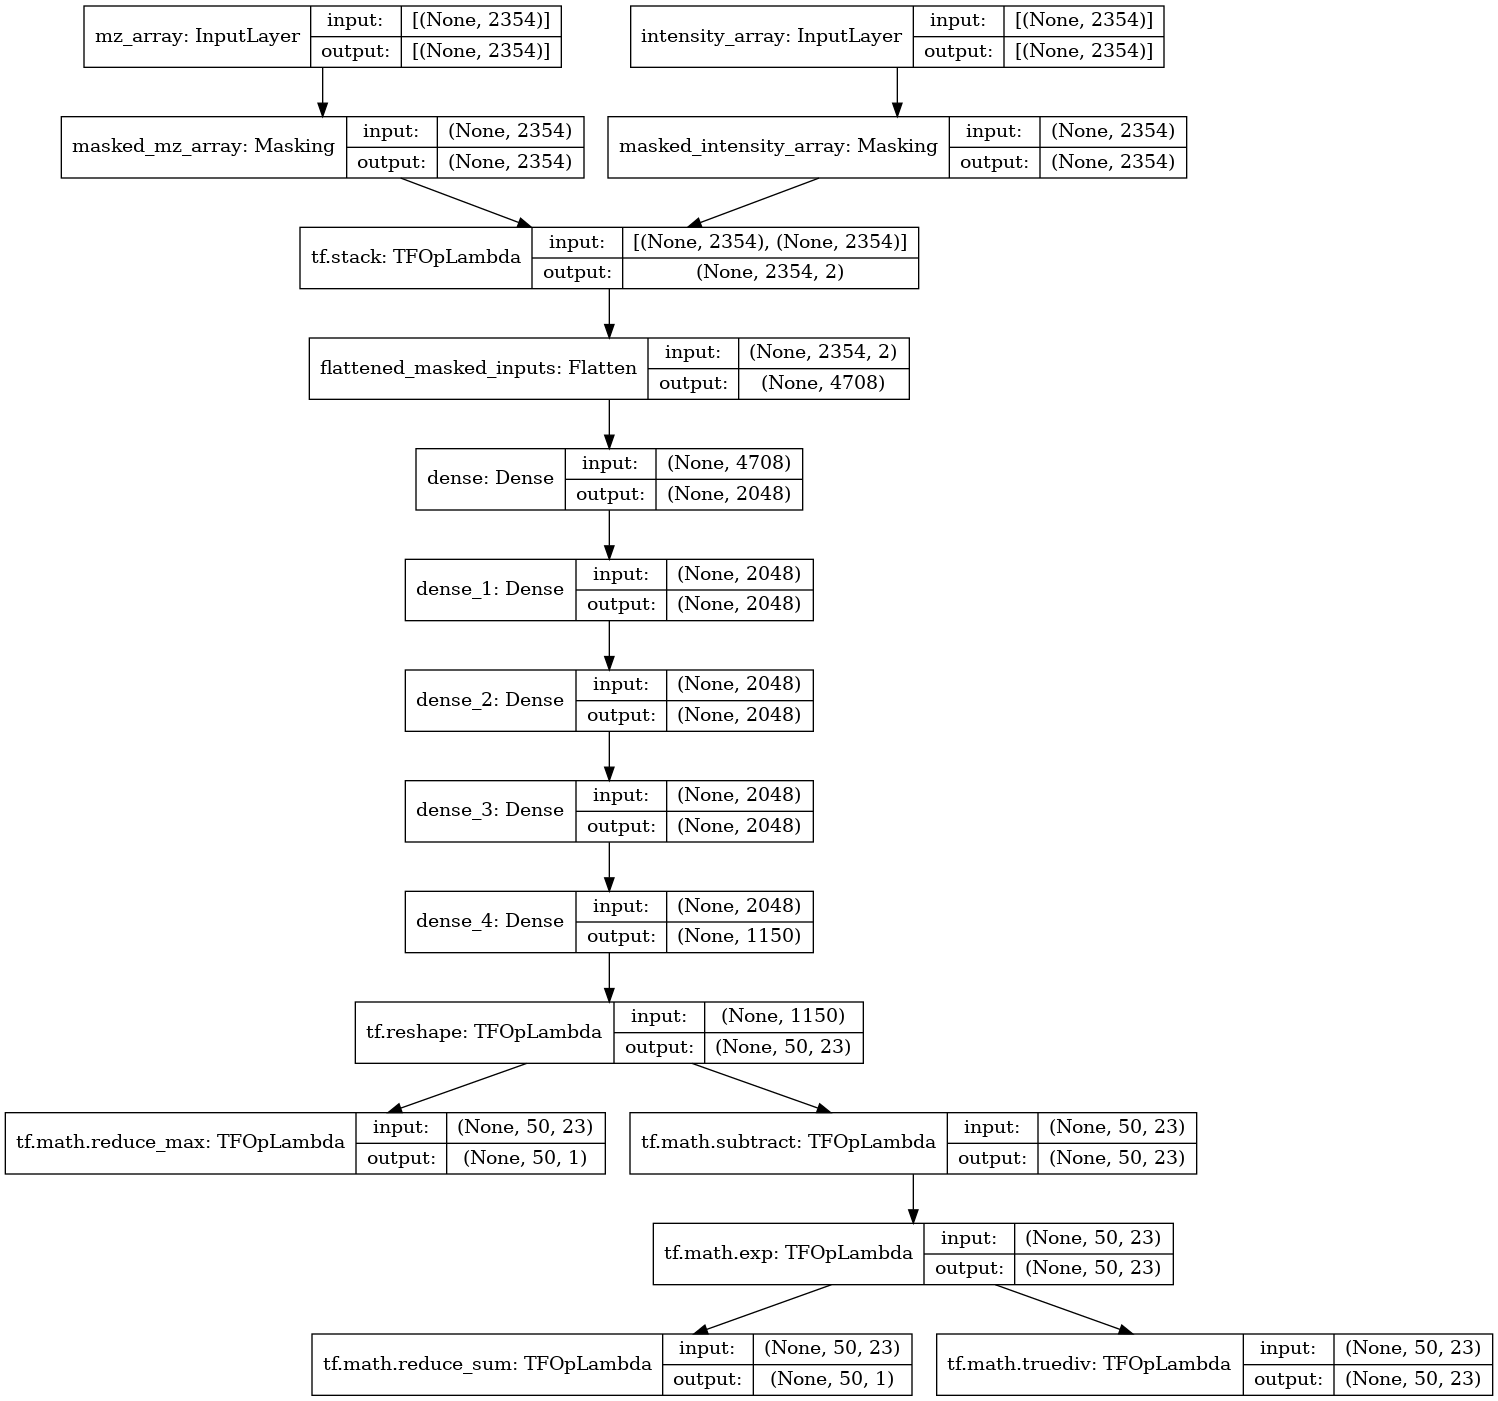

In [31]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True
)

In [32]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")
    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_dense_pride_20211023-131020"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mz_array (InputLayer)           [(None, 2354)]       0                                            
__________________________________________________________________________________________________
intensity_array (InputLayer)    [(None, 2354)]       0                                            
__________________________________________________________________________________________________
masked_mz_array (Masking)       (None, 2354)         0           mz_array[0][0]                   
__________________________________________________________________________________________________
masked_intensity_array (Masking (None, 2354)         0           intensity_array[0][0]            
_______________________________________________________________

In [33]:
with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
    file.write(model.to_json())

In [34]:
with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
    file.write(model.to_yaml())

## Training the Tensorflow Model

In [35]:
callback_list = callbacks.create_callbacks(
            tensorboard=True,
            progressbar=False,
            reduce_lr=False,
            early_stopping=False,
            checkpoints=False,
            csv=True,
            base_path=MODEL_PATH,
)
callback_list

In [36]:
training_dataset = datasets[TRAIN_TYPE].repeat()
validation_dataset = datasets[TEST_TYPE].repeat()

In [37]:
STEPS_PER_EPOCH = 5_000

In [38]:
model.fit(
    x=training_dataset,
    validation_data=validation_dataset, 
    validation_steps=STEPS_PER_EPOCH // 5,
    epochs=100,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callback_list,
)

Epoch 1/100
5000/5000 [==============================] - 176s 17ms/step - loss: 7.2873 - sparse_categorical_accuracy: 0.5473 - jaccard_batch_distance: 0.4598 - leuvenshtein_batch_distance: 16.9397 - val_loss: 6.7107 - val_sparse_categorical_accuracy: 0.5837 - val_jaccard_batch_distance: 0.4064 - val_leuvenshtein_batch_distance: 15.2564
Epoch 2/100
5000/5000 [==============================] - 87s 17ms/step - loss: 6.5571 - sparse_categorical_accuracy: 0.5932 - jaccard_batch_distance: 0.4304 - leuvenshtein_batch_distance: 14.6619 - val_loss: 6.7258 - val_sparse_categorical_accuracy: 0.5827 - val_jaccard_batch_distance: 0.4061 - val_leuvenshtein_batch_distance: 15.2931
Epoch 3/100
5000/5000 [==============================] - 83s 17ms/step - loss: 6.7904 - sparse_categorical_accuracy: 0.5787 - jaccard_batch_distance: 0.4411 - leuvenshtein_batch_distance: 15.7005 - val_loss: 6.7612 - val_sparse_categorical_accuracy: 0.5805 - val_jaccard_batch_distance: 0.4513 - val_leuvenshtein_batch_distan

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 91s 18ms/step - loss: 6.6370 - sparse_categorical_accuracy: 0.5882 - jaccard_batch_distance: 0.5012 - leuvenshtein_batch_distance: 15.6523 - val_loss: 6.4885 - val_sparse_categorical_accuracy: 0.5974 - val_jaccard_batch_distance: 0.4516 - val_leuvenshtein_batch_distance: 15.7111
Epoch 21/100
5000/5000 [==============================] - 92s 18ms/step - loss: 6.5324 - sparse_categorical_accuracy: 0.5947 - jaccard_batch_distance: 0.4931 - leuvenshtein_batch_distance: 15.3976 - val_loss: 6.4581 - val_sparse_categorical_accuracy: 0.5993 - val_jaccard_batch_distance: 0.4505 - val_leuvenshtein_batch_distance: 15.6301
Epoch 22/100
2720/5000 [===============>..............] - ETA: 35s - loss: 6.4481 - sparse_categorical_accuracy: 0.5999 - jaccard_batch_distance: 0.4787 - leuvenshtein_batch_distance: 15.3066

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 94s 19ms/step - loss: 6.4697 - sparse_categorical_accuracy: 0.5986 - jaccard_batch_distance: 0.4629 - leuvenshtein_batch_distance: 15.5199 - val_loss: 6.4757 - val_sparse_categorical_accuracy: 0.5982 - val_jaccard_batch_distance: 0.4513 - val_leuvenshtein_batch_distance: 15.6755
Epoch 32/100
5000/5000 [==============================] - 94s 19ms/step - loss: 6.6097 - sparse_categorical_accuracy: 0.5899 - jaccard_batch_distance: 0.4717 - leuvenshtein_batch_distance: 15.8176 - val_loss: 6.4661 - val_sparse_categorical_accuracy: 0.5988 - val_jaccard_batch_distance: 0.4509 - val_leuvenshtein_batch_distance: 15.6606
Epoch 33/100
5000/5000 [==============================] - 93s 19ms/step - loss: 6.1341 - sparse_categorical_accuracy: 0.6194 - jaccard_batch_distance: 0.4686 - leuvenshtein_batch_distance: 14.6866 - val_loss: 6.4721 - val_sparse_categorical_accuracy: 0.5985 - val_jaccard_batch_distance: 0.4503 - val_leuvenshtein_batch_distance: 15.6726

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 91s 18ms/step - loss: 6.6289 - sparse_categorical_accuracy: 0.5887 - jaccard_batch_distance: 0.4845 - leuvenshtein_batch_distance: 15.7490 - val_loss: 6.4870 - val_sparse_categorical_accuracy: 0.5975 - val_jaccard_batch_distance: 0.4513 - val_leuvenshtein_batch_distance: 15.6972
Epoch 44/100
5000/5000 [==============================] - 93s 19ms/step - loss: 6.6837 - sparse_categorical_accuracy: 0.5853 - jaccard_batch_distance: 0.4931 - leuvenshtein_batch_distance: 15.7421 - val_loss: 6.4695 - val_sparse_categorical_accuracy: 0.5986 - val_jaccard_batch_distance: 0.4513 - val_leuvenshtein_batch_distance: 15.6608
Epoch 45/100
5000/5000 [==============================] - 93s 19ms/step - loss: 6.6473 - sparse_categorical_accuracy: 0.5876 - jaccard_batch_distance: 0.5287 - leuvenshtein_batch_distance: 15.4230 - val_loss: 6.4683 - val_sparse_categorical_accuracy: 0.5987 - val_jaccard_batch_distance: 0.4511 - val_leuvenshtein_batch_distance: 15.6667

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 91s 18ms/step - loss: 6.2520 - sparse_categorical_accuracy: 0.6121 - jaccard_batch_distance: 0.4540 - leuvenshtein_batch_distance: 15.0914 - val_loss: 6.4672 - val_sparse_categorical_accuracy: 0.5988 - val_jaccard_batch_distance: 0.4514 - val_leuvenshtein_batch_distance: 15.6579
Epoch 56/100
5000/5000 [==============================] - 91s 18ms/step - loss: 6.6189 - sparse_categorical_accuracy: 0.5894 - jaccard_batch_distance: 0.4640 - leuvenshtein_batch_distance: 15.8709 - val_loss: 6.4597 - val_sparse_categorical_accuracy: 0.5992 - val_jaccard_batch_distance: 0.4510 - val_leuvenshtein_batch_distance: 15.6476
Epoch 57/100
4679/5000 [===========================>..] - ETA: 4s - loss: 6.2721 - sparse_categorical_accuracy: 0.6109 - jaccard_batch_distance: 0.4891 - leuvenshtein_batch_distance: 14.8509

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 92s 18ms/step - loss: 6.1419 - sparse_categorical_accuracy: 0.6189 - jaccard_batch_distance: 0.4678 - leuvenshtein_batch_distance: 14.6824 - val_loss: 6.4546 - val_sparse_categorical_accuracy: 0.5995 - val_jaccard_batch_distance: 0.4507 - val_leuvenshtein_batch_distance: 15.6312
Epoch 62/100
5000/5000 [==============================] - 91s 18ms/step - loss: 6.5090 - sparse_categorical_accuracy: 0.5962 - jaccard_batch_distance: 0.4838 - leuvenshtein_batch_distance: 15.3876 - val_loss: 6.4712 - val_sparse_categorical_accuracy: 0.5985 - val_jaccard_batch_distance: 0.4509 - val_leuvenshtein_batch_distance: 15.6626
Epoch 63/100
5000/5000 [==============================] - 89s 18ms/step - loss: 6.5686 - sparse_categorical_accuracy: 0.5925 - jaccard_batch_distance: 0.4794 - leuvenshtein_batch_distance: 15.6784 - val_loss: 6.4720 - val_sparse_categorical_accuracy: 0.5985 - val_jaccard_batch_distance: 0.4514 - val_leuvenshtein_batch_distance: 15.6693

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 90s 18ms/step - loss: 6.1881 - sparse_categorical_accuracy: 0.6161 - jaccard_batch_distance: 0.4538 - leuvenshtein_batch_distance: 14.9052 - val_loss: 6.4866 - val_sparse_categorical_accuracy: 0.5976 - val_jaccard_batch_distance: 0.4520 - val_leuvenshtein_batch_distance: 15.7100
Epoch 83/100
5000/5000 [==============================] - 89s 18ms/step - loss: 6.2592 - sparse_categorical_accuracy: 0.6117 - jaccard_batch_distance: 0.4554 - leuvenshtein_batch_distance: 15.0857 - val_loss: 6.4521 - val_sparse_categorical_accuracy: 0.5997 - val_jaccard_batch_distance: 0.4504 - val_leuvenshtein_batch_distance: 15.6222
Epoch 84/100
4500/5000 [==========================>...] - ETA: 7s - loss: 6.6308 - sparse_categorical_accuracy: 0.5886 - jaccard_batch_distance: 0.4651 - leuvenshtein_batch_distance: 15.9014

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 92s 18ms/step - loss: 6.6030 - sparse_categorical_accuracy: 0.5903 - jaccard_batch_distance: 0.4819 - leuvenshtein_batch_distance: 15.7677 - val_loss: 6.4605 - val_sparse_categorical_accuracy: 0.5992 - val_jaccard_batch_distance: 0.4496 - val_leuvenshtein_batch_distance: 15.6574
Epoch 95/100
5000/5000 [==============================] - 89s 18ms/step - loss: 6.3648 - sparse_categorical_accuracy: 0.6051 - jaccard_batch_distance: 0.4805 - leuvenshtein_batch_distance: 15.1985 - val_loss: 6.4660 - val_sparse_categorical_accuracy: 0.5988 - val_jaccard_batch_distance: 0.4500 - val_leuvenshtein_batch_distance: 15.6645
Epoch 96/100
2779/5000 [===============>..............] - ETA: 33s - loss: 6.2031 - sparse_categorical_accuracy: 0.6151 - jaccard_batch_distance: 0.4552 - leuvenshtein_batch_distance: 15.0044

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Evaluating the Tensorflow Model

In [39]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

eval_evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

train_evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[TRAIN_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [40]:
train_evaluator.evaluate_model(model)

1250/1250 [==============================] - 18s 13ms/step - loss: 6.0403 - sparse_categorical_accuracy: 0.6252 - jaccard_batch_distance: 0.4833 - leuvenshtein_batch_distance: 14.3500


[6.040292739868164, 0.6252480149269104, 0.4833381474018097, 14.350025177001953]

In [41]:
eval_df, (x_eval, y_eval, y_pred) = train_evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

,predicted,true
0,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,S V P P H E L I S S I R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,D P A Q E T W V G Y R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,A A I A Q A Q T Q F G L P S T G R P D S A T F K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,L R P H V V D S S L T I D E A W R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,F S H P H L E T V G P K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
5,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,T L E H L A S T K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
6,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,E G D L V V M T A G T L P G V S G S T D L V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
7,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,I D M S E Y M(Oxidation) E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
8,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,S M G S A T A V N M V R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
9,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,T Q L D Q Q A G Q V D T L K R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


In [42]:
eval_evaluator.evaluate_model(model)

1250/1250 [==============================] - 18s 13ms/step - loss: 6.3451 - sparse_categorical_accuracy: 0.6063 - jaccard_batch_distance: 0.5055 - leuvenshtein_batch_distance: 14.8952


[6.345068454742432, 0.6063389778137207, 0.5055138468742371, 14.895224571228027]

In [43]:
eval_df, (x_eval, y_eval, y_pred) = eval_evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

,predicted,true
0,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,T V D V S P E A V T I E A T G S S D K L E A M L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,Q A A E I W E S I R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,W V E I D N H D D L A K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,V L G T G E I T V A L Q V T V D A V S G S A K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,G A V A G P F D S W I V L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
5,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,R I Y P I V T V I T E D G Y R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
6,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,R W T P C F D C G V C P Q M(Oxidation) D T H I Q I G P T G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
7,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,H F L G K P E L G S I G S E G W L G Y D G Q G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
8,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,A E S D E S A A L A E L D R L T N K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
9,A V T P S V A A T Y D _ _ _ _ _ R _ _ _ _ _ _ G _ _ _ _ _ _ _ E _ _ _ _ _ _ _ _ _ _ _ _ R _ _ _ _ _,A A S Q L G W L D E R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>